In [228]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from sklearn.preprocessing import KBinsDiscretizer

@dataclass
class HigherOrderResult:
    s0: np.ndarray
    s1: np.ndarray
    q: np.ndarray
    rho_omega_phi: float
    eta_phi_given_omega: float
    eta_squared: float
    omega_vals: np.ndarray
    phi_vals: np.ndarray
    conditional_means: np.ndarray
    omega_binned: np.ndarray

def omega(x, y, a=1.0, b=1.0):
    return a * x + b * y

def phi(x, y, c=1.0, d=1.0, phi_hat=0.8):
    phi_bar = c * x + d * y
    var_phi_bar = np.var(phi_bar)
    sigma_noise = np.sqrt((phi_hat**-2 - 1) * var_phi_bar)
    noise = np.random.normal(0, sigma_noise, size=phi_bar.shape)
    return phi_bar + noise

def simulate_higher_order(n=300, cov=0.0, a=1.0, b=1.0, c=1.2, d=0.8, phi_hat=1, bins=20):
    mean = [0, 0]
    cov_matrix = [[1, cov], [cov, 1]]
    x, y = np.random.multivariate_normal(mean, cov_matrix, n).T

    s0 = np.vstack([x, y]).T
    omega_vals = omega(x, y, a, b)
    phi_vals = phi(x, y, c, d, phi_hat)

    rho_omega_phi = np.corrcoef(omega_vals, phi_vals)[0, 1]

    binner = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
    omega_binned = binner.fit_transform(omega_vals.reshape(-1, 1)).flatten()

    bin_means = np.array([
        phi_vals[omega_binned == b].mean() if np.any(omega_binned == b) else np.nan
        for b in range(bins)
    ])
    conditional_means = np.array([bin_means[int(b)] for b in omega_binned])

    var_phi = np.var(phi_vals)
    var_E_q_given_omega = np.var(conditional_means[~np.isnan(conditional_means)])
    eta_squared = var_E_q_given_omega / var_phi
    eta = np.sqrt(eta_squared)

    return HigherOrderResult(
        s0=s0,
        s1=omega_vals,
        q=phi_vals,
        rho_omega_phi=rho_omega_phi,
        eta_phi_given_omega=eta,
        eta_squared=eta_squared,
        omega_vals=omega_vals,
        phi_vals=phi_vals,
        conditional_means=conditional_means,
        omega_binned=omega_binned
    )

In [170]:
colors = {
    'red':    '#EC4C4C',
    'green':  '#70D07C',
    'blue':   '#4C9CED',
    'yellow': '#FFC857',
    'orange': '#F28E2B',
    'purple': '#A066D3'
}

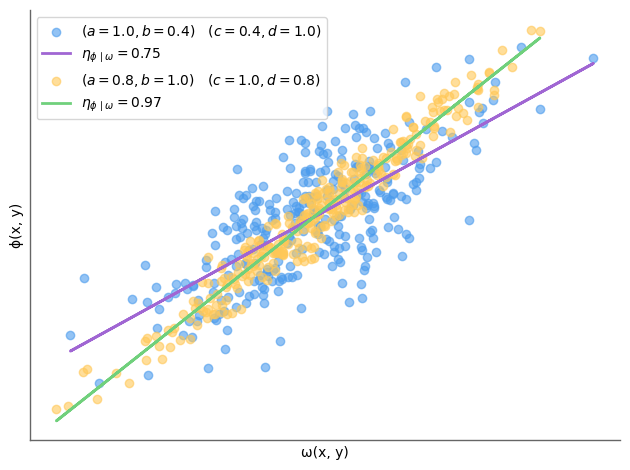

In [238]:
phi_hat = 1

fig, ax = plt.subplots()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1)
ax.spines['bottom'].set_color('#666')
ax.spines['left'].set_linewidth(1)
ax.spines['left'].set_color('#666')

plt.xticks([])
plt.yticks([])

a = 1
b = .4
c = .4
d = 1
result = simulate_higher_order(cov=0, a=a, b=b, c=c, d=d, phi_hat=phi_hat)
plt.scatter(result.omega_vals, result.phi_vals, alpha=0.6, color=colors['yellow'], label=f'$(a={a:.1f}, b={b:.1f}) \quad (c={c:.1f}, d={d:.1f})$')
m, z = np.polyfit(result.omega_vals, result.phi_vals, 1)
plt.plot(result.omega_vals, m * result.omega_vals + z, color=colors['green'], label=r'$\eta_{\phi \mid \omega}='+f'{result.eta_phi_given_omega:.2f}$', linewidth=2)


a = .8
b = 1
c = 1
d = .8
result = simulate_higher_order(cov=0, a=a, b=b, c=c, d=d, phi_hat=phi_hat)
plt.scatter(result.omega_vals, result.phi_vals, alpha=0.6, color=colors['blue'], label=f'$(a={a:.1f}, b={b:.1f}) \quad (c={c:.1f}, d={d:.1f})$')
m, z = np.polyfit(result.omega_vals, result.phi_vals, 1)
plt.plot(result.omega_vals, m * result.omega_vals + z, color=colors['purple'], label=r'$\eta_{\phi \mid \omega}='+f'{result.eta_phi_given_omega:.2f}$', linewidth=2)

plt.xlabel('ω(x, y)')
plt.ylabel('ϕ(x, y)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("omega-vs-phi.pdf")
plt.show()

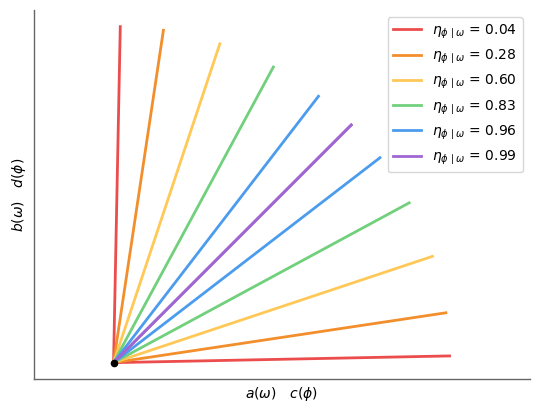

In [204]:
n = 100000
z = np.linspace(0, n-1, n)

fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='datalim')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1)
ax.spines['bottom'].set_color('#666')
ax.spines['left'].set_linewidth(1)
ax.spines['left'].set_color('#666')

plt.xticks([])
plt.yticks([])

a = 5
b = .1
c = .1
d = 5
norm = np.linalg.norm([a, b])
result = simulate_higher_order(n=n, a=a, b=b, c=c, d=d)
plt.plot(a * z / norm, b * z / norm, color=colors['red'], label=r"$\eta_{\phi \mid \omega}$ = " + f"{result.eta_phi_given_omega:.2f}", linewidth=2)
plt.plot(c * z / norm, d * z / norm, color=colors['red'], linewidth=2)

a = 1
b = .15
c = .15
d = 1
norm = np.linalg.norm([a, b])
result = simulate_higher_order(n=n, a=a, b=b, c=c, d=d)
plt.plot(a * z / norm, b * z / norm, color=colors['orange'], label=r"$\eta_{\phi \mid \omega}$ = " + f"{result.eta_phi_given_omega:.2f}", linewidth=2)
plt.plot(c * z / norm, d * z / norm, color=colors['orange'], linewidth=2)

a = .6
b = .2
c = .2
d = .6
norm = np.linalg.norm([a, b])
result = simulate_higher_order(n=n, a=a, b=b, c=c, d=d)
plt.plot(a * z / norm, b * z / norm, color=colors['yellow'], label=r"$\eta_{\phi \mid \omega}$ = " + f"{result.eta_phi_given_omega:.2f}", linewidth=2)
plt.plot(c * z / norm, d * z / norm, color=colors['yellow'], linewidth=2)

a = .37
b = .2
c = .2
d = .37
norm = np.linalg.norm([a, b])
result = simulate_higher_order(n=n, a=a, b=b, c=c, d=d)
plt.plot(a * z / norm, b * z / norm, color=colors['green'], label=r"$\eta_{\phi \mid \omega}$ = " + f"{result.eta_phi_given_omega:.2f}", linewidth=2)
plt.plot(c * z / norm, d * z / norm, color=colors['green'], linewidth=2)

a = .26
b = .2
c = .2
d = .26
norm = np.linalg.norm([a, b])
result = simulate_higher_order(n=n, a=a, b=b, c=c, d=d)
plt.plot(a * z / norm, b * z / norm, color=colors['blue'], label=r"$\eta_{\phi \mid \omega}$ = " + f"{result.eta_phi_given_omega:.2f}", linewidth=2)
plt.plot(c * z / norm, d * z / norm, color=colors['blue'], linewidth=2)

a = .2
b = .2
c = .2
d = .2
norm = np.linalg.norm([a, b])
result = simulate_higher_order(n=n, a=a, b=b, c=c, d=d)
plt.plot(a * z / norm, b * z / norm, color=colors['purple'], label=r"$\eta_{\phi \mid \omega}$ = " + f"{result.eta_phi_given_omega:.2f}", linewidth=2)
plt.plot(c * z / norm, d * z / norm, color=colors['purple'], linewidth=2)

plt.scatter([0], [0], color="black", s=20, zorder=2000)

plt.legend()
plt.grid(False)
plt.xlabel(r"$a (\omega) \quad c (\phi$)")
plt.ylabel(r"$b (\omega) \quad d (\phi$)")
plt.savefig("omega-phi.pdf")
plt.show()